# Proyecto 04 - Procesamiento del Lenguaje Natural


## TP III GASPAR GONZALEZ WULFSOHN

Vamos a trabajar con el corpus de críticas sobre productos adquiridos por usuarios de la plataforma AMAZON. Para realizar este informe tuvimos en cuenta la suiguiente licencia.

LICENSE

By accessing the Multilingual Amazon Reviews Corpus ("Reviews Corpus"), you agree that the Reviews Corpus is an Amazon Service subject to the Amazon.com Conditions of Use (https://www.amazon.com/gp/help/customer/display.html/ref=footer_cou?ie=UTF8&nodeId=508088) and you agree to be bound by them, with the following additional conditions:

In addition to the license rights granted under the Conditions of Use, Amazon or its content providers grant you a limited, non-exclusive, non-transferable, non-sublicensable, revocable license to access and use the Reviews Corpus for purposes of academic research. You may not resell, republish, or make any commercial use of the Reviews Corpus or its contents, including use of the Reviews Corpus for commercial research, such as research related to a funding or consultancy contract, internship, or other relationship in which the results are provided for a fee or delivered to a for-profit organization. You may not (a) link or associate content in the Reviews Corpus with any personal information (including Amazon customer accounts), or (b) attempt to determine the identity of the author of any content in the Reviews Corpus. If you violate any of the foregoing conditions, your license to access and use the Reviews Corpus will automatically terminate without prejudice to any of the other rights or remedies Amazon may have.

## Exploración de datos y Procesamiento del Lenguaje Natural

### Importamos las librerías necesarias para realizar el trabajo


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import itertools
import nltk
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
import string
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import unicodedata
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('spanish')
stopword_list.remove('no')
import spacy  
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import nltk
#nltk.download()
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn
from unicodedata import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from nltk.corpus import wordnet
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gaspa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaspa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Nuevos desafios realizados en este trabajo.

1. Vamos a utilizar utilizar las biblioteca SPacy para Lemmatizar en español evaluar su rendimiento.

2. Realizar un TF-IDF utilizando como guía el capítulo 6.3 Word Frequencies with TfidfVectorizer, del libro "Deep Learning for Natural Language Processing" de Jason Brownlee. 

3. Llevar las variables a clasificar a un tipo binario de críticas positivas y negativas. ¿Será mejor el rendimiento de los modelos elegidos en la predicción del tipo de críticas?

4. Por último, vamos a sumar el Modelo XGBoostClassifier para comparar rendimientos. ¿Será un modelo más eficiente que el Linearsvc e Sklearn?





## 1. Carga de datos
### Cargamos los datos en formato .json
Vamos a cargar los datos con la función pd.read_json de Pandas y obtener una idea precisa del dataframe

In [2]:
!python -m spacy download es_core_news_sm

You should consider upgrading via the 'C:\Users\gaspa\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
# Cargamos los datos de entrenamiento
df_train = pd.read_json ('dataset_es_train.json', lines = True)


[+] Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [4]:
# Cargamos los datos de testeo
df_test = pd.read_json ('dataset_es_test.json', lines = True)

In [5]:
# Cargamos los dev
df_dev = pd.read_json ('dataset_es_dev.json', lines = True)

Vamos a realizar una muestra aleatoria de 10000 instancias para poder trabajar en menor tiempo

In [6]:
# Muestra aleatoria de 10000 instancias
experiment_size = int(10000)
completerandom_idx = df_train.sample(int(experiment_size),random_state = 21).index
df_lem = df_train.loc[completerandom_idx,:]

In [7]:
# 10.000 filas y 8 columnas
df_lem.shape


(10000, 8)

Vamos a comenzar realizando una lemmatización de las críticas. Para ello vamos a incorporar la librería Spacy que posee una función para realizarlo en español.

In [8]:
# Vamos a definir una función para traducir estas etiquetas a los valores de POS que entiende `wordnet_lemmatizer`.


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
# Insanciamos el núcleo de palabras en español de la librería Spacy
nlp = spacy.load('es_core_news_sm')

In [10]:
# Instanciamos las stopwords del español
stopwords = nltk.corpus.stopwords.words('spanish')

Defininmos el preprocesamiento y lematización de las críticas 

In [11]:
# Definimos el preprocesamiento 
criticas_lista=[]

for critica in df_lem.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    critica=re.sub("[^a-zA-Z]"," ",str(critica))
    # Pasamos todo a minúsculas
    critica=critica.lower()
    # Tokenizamos para separar las palabras
    critica=nltk.word_tokenize(critica)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [nlp(w, get_wordnet_pos(w)) for w in critica]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    critica = [palabra for palabra in critica if len(palabra)>3]
    # Sacamos las Stopwords
    critica = [palabra for palabra in critica if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    critica=" ".join(critica)
    #dataset["titular_normalizado"] = titular_list
    criticas_lista.append(critica)

In [12]:
#Incluímos el resultado en el el dataframe
df_lem['criticas_lem'] =  criticas_lista

In [13]:
# Removemos los acentos y normalizamos con una función de la librería 'unicodedata'
remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

In [14]:
# Creamos una nueva columna con las críticas normalizadas y procesadas
df_lem['criticas_lem'] = df_lem['criticas_lem'].apply(remove_accent)

Vamos a realizar el mismo procedimiento para la lista de títulos. Esta variable no había sido utilizada en el TP3, por lo tanto esperamos que al tener una dimensionalidad mayor, los modelos predictores obtengan un mejor resultado.

In [15]:
# Definimos el preprocesamiento
titulos_lista=[]

for titulo in df_lem.review_title:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titulo=re.sub("[^a-zA-Z]"," ",str(titulo))
    # Pasamos todo a minúsculas
    titulo=titulo.lower()
    # Tokenizamos para separar las palabras
    titulo=nltk.word_tokenize(titulo)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [nlp(w, get_wordnet_pos(w)) for w in titulo]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    titulo = [palabra for palabra in titulo if len(palabra)>3]
    # Sacamos las Stopwords
    titulo = [palabra for palabra in titulo if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    titulo=" ".join(titulo)
    #dataset["titular_normalizado"] = titular_list
    titulos_lista.append(titulo)

In [16]:
# Incluímos en el dataframe la lista de títulos
df_lem['titulos_lem'] = titulos_lista

In [17]:
# Creamos una nueva columna con las críticas normalizadas y procesadas
df_lem['titulos_lem'] = df_lem['titulos_lem'].apply(remove_accent)

Realizamos una stemización de igula manera a la realizada en el TP3

In [18]:
# Instanciamos la función para stemizar
stemmer = PorterStemmer()

In [19]:
# Instanciamos el preprocesamiento y la stemización

lista_criticas=[]
for critica in df_lem.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    critica=re.sub("[^a-zA-Z]"," ",str(critica))
    # Pasamos todo a minúsculas
    critica=critica.lower()
    # Tokenizamos para separar las palabras del titular
    critica=nltk.word_tokenize(critica)
    # Eliminamos las palabras de menos de 3 letras
    critica = [palabra for palabra in critica if len(palabra)>3]
    # Sacamos las Stopwords
    critica = [palabra for palabra in critica if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    critica=[stemmer.stem(palabra) for palabra in critica]
    # Por ultimo volvemos a unir el titular
    critica=" ".join(critica)
    
    # Vamos armando una lista con todos los titulares
    lista_criticas.append(critica)
    #dataset["titular_normalizado"] = titular_list

In [20]:
# Incluímos lo realizado en en el dataframe
df_lem['criticas_stem'] = lista_criticas

In [21]:
# Removemos los acentos
df_lem['criticas_stem'] = df_lem['criticas_stem'].apply(remove_accent)


In [22]:
# Obtenemos una idea del dataframe hasta el momento
df_lem.head(1)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,criticas_lem,titulos_lem,criticas_stem
127855,es_0978127,product_es_0855439,reviewer_es_0567957,4,"Me ha gustado la estructura, se desliza bien y...",bonito y funcional,es,home,gustado estructura desliza bien gran capacidad...,bonito funcional,gustado estructura desliza bien gran capacidad...


## Variables binarias
Vamos a transformar las variables multiclase a binarias. Para ello vamos a considerar que cualquier crítica con menos de 3 estrellas es una crítica negativa. 

In [23]:
# Pasamos las variables multiclase a binarias
df_lem['critica_negativa'] = df_lem['stars'].apply(lambda x: 1 if x < 3 else 0)


## TF-IDF
Utilizaremos la función tfidf de Sklearn para obtener una vectorización diferente a la realizada en el TP3 con Countvectorizer.

In [24]:
# Instanciamos la función con un mínimo de 10 columnas
tfidf = TfidfVectorizer(min_df = 10)

In [25]:
# Utilizamos la función sobre las críticas
tfidf_result = tfidf.fit_transform(df_lem.criticas_lem).toarray()

In [26]:
# Agregamos el resultado al dataframe
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ['palabra_' + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_lem.index
df_lem = pd.concat([df_lem, tfidf_df], axis=1)

In [27]:
#df_lem = pd.concat([df_lem, doc2vec_df], axis=1)

In [28]:
df_lem.head(1)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,criticas_lem,titulos_lem,...,palabra_wifi,palabra_windows,palabra_xiaomi,palabra_xima,palabra_ximo,palabra_youtube,palabra_zapatillas,palabra_zapatos,palabra_zona,palabra_zonas
127855,es_0978127,product_es_0855439,reviewer_es_0567957,4,"Me ha gustado la estructura, se desliza bien y...",bonito y funcional,es,home,gustado estructura desliza bien gran capacidad...,bonito funcional,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Utilizamos .drop de pandas para retirar las columnas que consideramos irrelevantes o redundantes
df_lem = df_lem.drop(['review_id', 'review_title', 'language', 'review_body', 'product_id', 'reviewer_id'], axis = 1)

In [30]:
# Utilizamos funciones lamda para retirar el texto
#df_lem['product_id'] = df_lem['product_id'].map(lambda x: x.lstrip('product_es_'))
#df_lem['reviewer_id'] = df_lem['reviewer_id'].map(lambda x: x.lstrip('reviewer_es_'))


Vamos a transformar la variable categórica del tipo de producto a una variable binaria con la función de pandas get_dummies

In [31]:
# Instanciamos al función de pandas get_dummies
reg = pd.get_dummies(df_lem.product_category, drop_first=False)


In [32]:
# unimos el resultado al dataframe 
df_lem = df_lem.join(reg, how = 'left', lsuffix = '_left', rsuffix = '_right')

In [33]:
df_lem.head()

,stars,product_category,criticas_lem,titulos_lem,criticas_stem,critica_negativa,palabra_abajo,palabra_abierta,palabra_abierto,palabra_abre,...,other,pc,personal_care_appliances,pet_products,shoes,sports,toy,video_games,watch,wireless
127855,4,home,gustado estructura desliza bien gran capacidad...,bonito funcional,gustado estructura desliza bien gran capacidad...,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6468,1,home,espera llegue tres fecha entrega primera pasa ...,llegado,espera llegu tre fecha entrega primera pasa am...,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
152307,4,digital_ebook_purchase,autor,descripci precisa,autor,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
14064,1,home,producto bien montar precio razonable compr ni...,problema plazos entrega,producto bien montar precio razon compr nico p...,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20862,1,apparel,despu meses recibido diademas devuelto dinero,mala experiencia,despu mese recibido diadema devuelto dinero,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Vamos a contabilizar cuantas críticas entran en la categoría de negativas

In [35]:
# Utilizamos la función value_counts 
df_lem.critica_negativa.value_counts(normalize = True)

0    0.5929
1    0.4071
Name: critica_negativa, dtype: float64

Podemos observar que aproximadamente el 40% de las críticas entran dentro de la categoría de negativas.

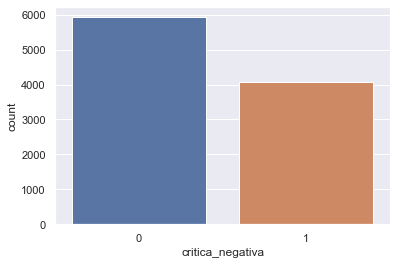

In [36]:
# Graficamos el conteo
sns.countplot(df_lem.critica_negativa)
plt.show()

Mediante el gráfico reafirmamos el resultado obtenido en el conteo.

Vamos a utilizar la función de worldcloud separando las críticas entre negativas y positivas para obtener una idea de las palabras con mayor frecuencia en cada categoría

In [37]:
# Filtramos por las críticas negativas
criticas_neg = df_lem.critica_negativa == 1

In [38]:
# Filtramos por las críticas positivas
criticas_pos = df_lem.critica_negativa == 0

In [39]:
# Instanciamos las críticas negativas
df_neg = df_lem[criticas_neg]

In [40]:
# # Instanciamos las críticas negativas
df_pos = df_lem[criticas_pos]

In [121]:
# Instanciamos la función de wordcloud 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    


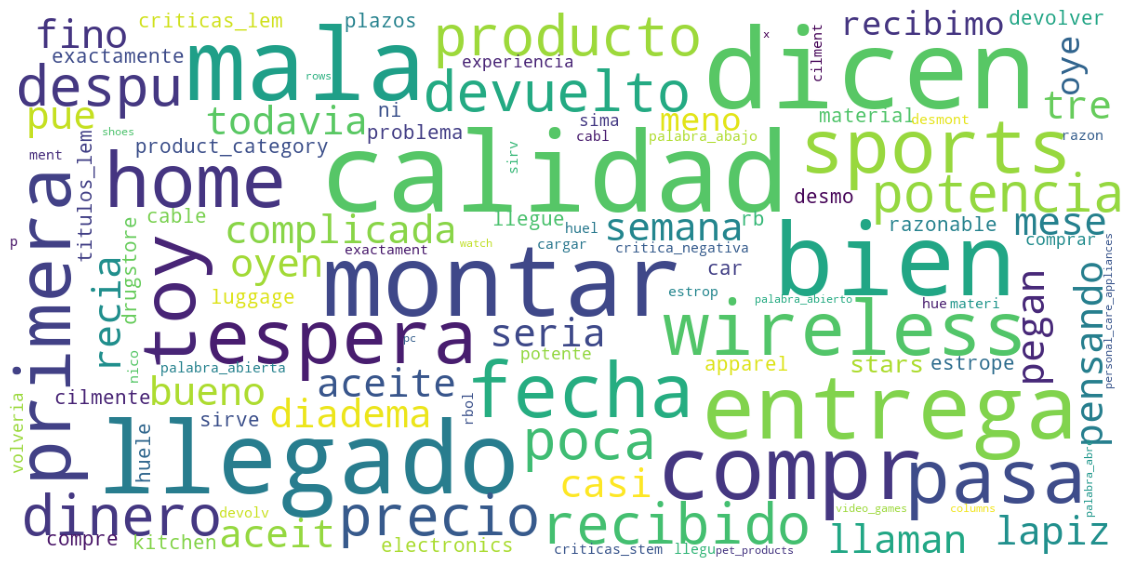

In [122]:
# print wordcloud con críticas negativas
show_wordcloud(df_neg)

Entre las palabras que más resaltan luego de aplicar la función, se encuentran "calidad", "mala", "llegado", entre otras. Podemos tener una aproximación de las palabras con mayor frecuncia entre las críticas negativas. 

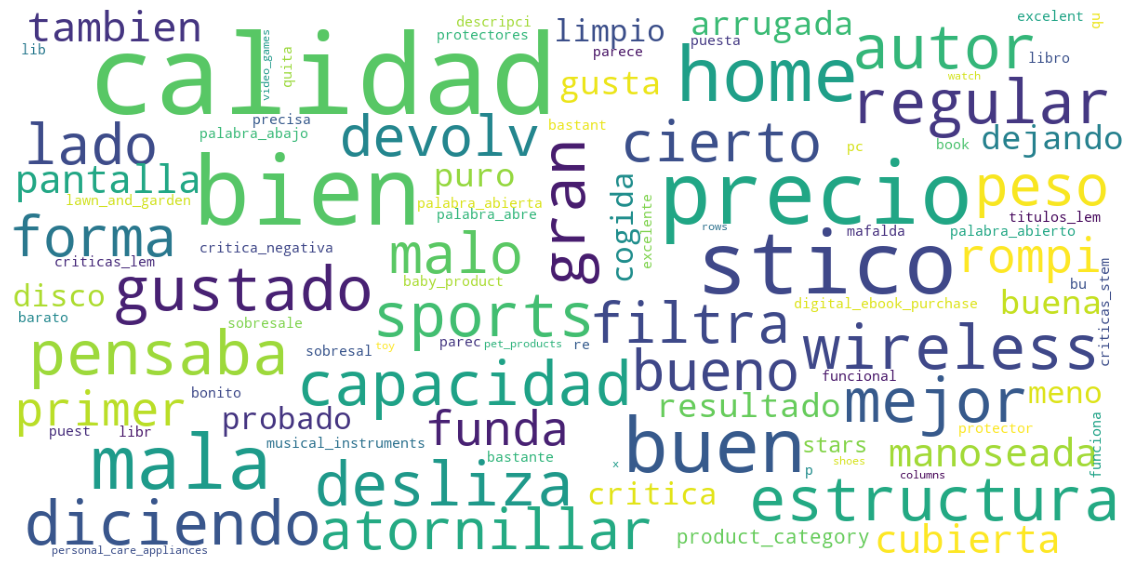

In [123]:
# print wordcloud con críticas positivas
show_wordcloud(df_pos)

Entre las palabras que más se destacan en las críticas positivas se encuentran: "bien", "calidad", "capacidad" y "precio" entre otras.

El siguiente paso es analizar la frecuencia de las palabras en los tipos de críticas.

In [43]:
# Instanciamos las críticas negativas
neg = pd.DataFrame(df_lem[df_lem.critica_negativa == 1])

In [44]:
# Toquenizamos las palabras filtradas por críticas negativas
negativa = []
for i in range(neg.shape[0]):
    critic = neg.iloc[i].criticas_lem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    negativa.append(critic)

negativa = list(itertools.chain(*negativa))

In [45]:
# Realizamos un dataframe con las frecuencias de las palabras
freq = nltk.FreqDist(negativa)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"]).sort_values('Frecuencia', ascending = False)
#frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
9,bien,772
8,producto,585
79,calidad,534
11,precio,254
180,funciona,249


Podemos observar que las 5 palabras con más frecuencia en las críticas negativas son: "bien", "producto", "calidad", "precio" y "funciona".

Vamos a graficar los resultados

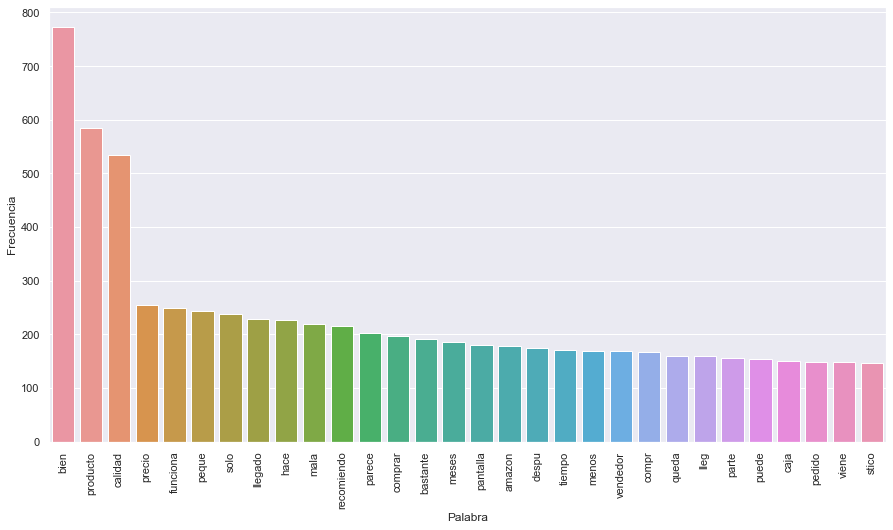

In [46]:
# Graficamos los resultados
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Las primeras 3 palabras: "bien", "producto" y "calidad" tienen una frecuencia que se destaca del resto en las críticas negativas. 

Relizamos el mismo procedimiento con las críticas positivas

In [47]:
# Instanciamos las críticas positivas
pos = pd.DataFrame(df_lem[df_lem.critica_negativa == 0])

In [48]:
# Toquenizamos las palabras filtradas por críticas negativas
positiva = []
for i in range(pos.shape[0]):
    critic = pos.iloc[i].criticas_lem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    positiva.append(critic)

positiva = list(itertools.chain(*positiva))

In [49]:
# Realizamos un dataframe con las frecuencias de las palabras
freq = nltk.FreqDist(positiva)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"]).sort_values('Frecuencia', ascending = False)
#frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
3,bien,1945
74,calidad,1037
30,precio,868
279,buena,776
42,producto,630


Las palabras con mayor frecuencia en las críticas positivas fueron: "bien", "calidad", "precio", "buena", "producto"

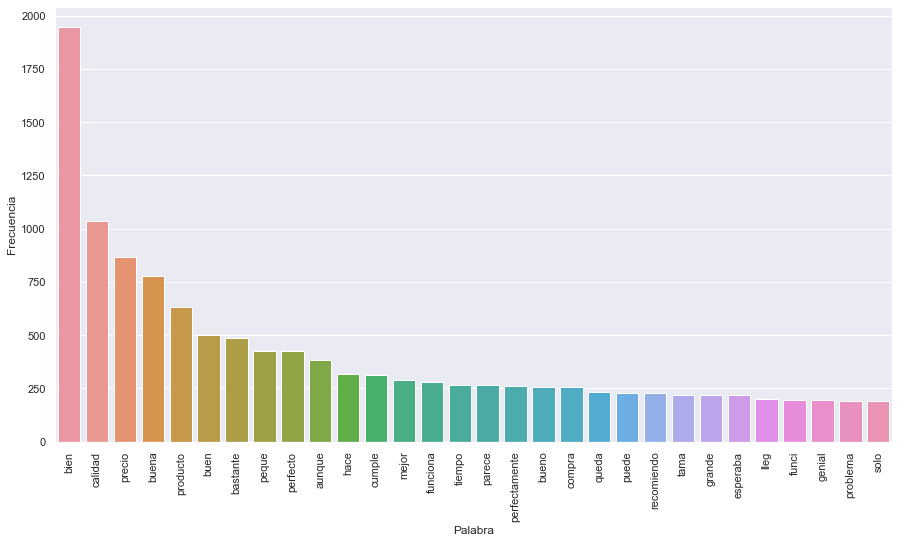

In [50]:
# Graficamos
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En el gráfico podemos observar que las palabras con más frecuencia se repiten tanto en las críticas positivas como en las negativas.

## Conclusiones sobre el análisis de las críticas

Al comparar las palabras con mayor frecuencia en las críticas, se pudo observar que las palabras se repiten tanto en las críticas positivas como en las negativas. Esto signfica que la frecuencia de palabras no representa en si mismo una buena variable para poder predecir el tipo de calificación debido a que no brinda información que nos permita discriminar entre un tipo de crítica positiva y otra negativa.
En este trabajo, vamos a realizar el modelado luego de utilizar el TF-IDF esperando un mejor rendimiento debido a que asigna un peso a aquellas palabras con menor frecuencia, y por lo tanto, permite obtener información más relevante para que los modelos elegidos puedan realizar la predicción.

## Modelado

Vamos a modelar utilizando los mismos algoritmos trabajados en el proyecto 3 sumando el XGBClassiffier con el objetivo de poner a prueba el modelo con mejor rendimiento, SVClinear de Sklearn.

Comenzamos procesando el datframe, retirando las variables que no son numéricas.

In [52]:
# Obtenemos un shape del dataframe
df_lem.shape

(10000, 1911)

In [53]:
# Retiramos las variables no utilizadas con la función drop de pandas
df_lem = df_lem.drop(['criticas_lem', 'titulos_lem', 'criticas_stem', 'product_category'], axis = 1)

In [54]:
# Obtenemos un vista del dataframe para corroborar las variables antes de utilizar los modelos
df_lem.head(1)

,stars,critica_negativa,palabra_abajo,palabra_abierta,palabra_abierto,palabra_abre,palabra_abrir,palabra_abrirlo,palabra_absolutamente,palabra_absoluto,...,other,pc,personal_care_appliances,pet_products,shoes,sports,toy,video_games,watch,wireless
127855,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Instanciamos las variables
X = df_lem.drop(['critica_negativa', 'stars'], axis = 1)
y = df_lem.critica_negativa

In [56]:
# Hacemos un train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Utilizaremos un modelo benchmark que sea la probabilidad de acertar con variables binarias. 

In [57]:
#Instanciamos el modelo benchmark
benchmark = 1/2

In [58]:
# Definimos la función para realizar una matriz de confusión
def confusion(y_test,y_pred):
    names=["Crítica positiva","Crítica negativa"]
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Modelo GaussianNB

In [59]:
# Instanciamos el modelo
nb = GaussianNB()

# Entrenamos con los datos de entrenamiento
nb.fit(X_train, y_train)

# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo GaussianNM es : ", nb.score(X_test, y_test))




La exactitud del modelo GaussianNM es :  0.691


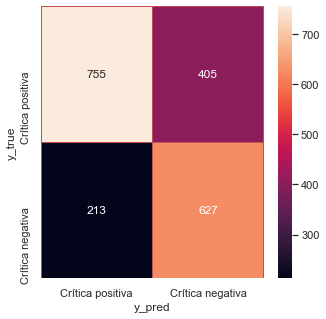

In [60]:
# Realizamos la matriz
y_pred=nb.predict(X_test)
confusion(y_test,y_pred)

En la matriz de confusión podemos observar que el modelo GaussianNB es más eficiente para predecir las criticas positivas que las negativas, obteniendo un valor de verdaderos positivos mayor.

In [61]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['1','0']))


Classification Report

              precision    recall  f1-score   support

           1       0.78      0.65      0.71      1160
           0       0.61      0.75      0.67       840

    accuracy                           0.69      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.71      0.69      0.69      2000



En el cuadro observamos que el modelo tiene una precision mayor para las críticas negativas. En cambio, el modelo fue más exhaustivo con las críticas positivas. 

### Modelo RandomForestClassifier

In [62]:
# Entrenamos el random forest classifier
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [63]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo Random Forest Classifier es : ", rf.score(X_test, y_test))

La exactitud del modelo Random Forest Classifier es :  0.7505


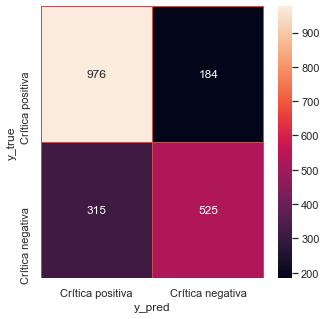

In [64]:
# Realizamos la matriz
y_pred=rf.predict(X_test)
confusion(y_test,y_pred)

Al igual que el modelo anterior, el RandomforestClassifier obtuvo un mejor rendimiento para predecir las clasidicaciones positvas. 

In [65]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Positiva','Negativa']))


Classification Report

              precision    recall  f1-score   support

    Positiva       0.76      0.84      0.80      1160
    Negativa       0.74      0.62      0.68       840

    accuracy                           0.75      2000
   macro avg       0.75      0.73      0.74      2000
weighted avg       0.75      0.75      0.75      2000



En este caso las 3 métricas demuestran mejor rendimiento para las críticas positivas.

#### Optimización de hiperparámetros

In [66]:
# Instanciamos el modelo de árboles random.
rf_rs = RandomForestClassifier(random_state=42)

In [67]:
# Número de árboles. Realizamos un rango de valores mediante la función de numpay linspace
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Número de variables a considerar en cada división de los nodos. Si es "auto", la cantidad es igual a n_variables (13) y si es 'sqrt' es sqrt(n_variables)
max_features = ['auto', 'sqrt']
# Máximo número de niveles en el árbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Mínimo número de muestras para dividir un nodo
min_samples_split = [2, 5, 10]
#  Mínimo número de muestras requerido en cada nodo
min_samples_leaf = [1, 2, 4]
#  Método de selección de muestras para entrenar cada árbol.
bootstrap = [True, False]
# Creamos la grilla
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [68]:
# Usamos la grilla para buscar los mejores hiperparámetros
# Primero creamos el modelo base para optimizar

# Random search de hiperparámtros usando una validación cruzada  de 3 K-folds
rf_random = RandomizedSearchCV(estimator = rf_rs, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1, random_state=42)

In [69]:
# Entrenamos
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   22.7s remaining:   19.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   42.8s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300]},
                   random_state=42, verbose=2)

In [70]:
# Imprimimos los mejores parámetros y el mejor rendimiento obtenido en r2
print("Mejores parametros: "+str(rf_random.best_params_))
print("Mejor Score: "+str(rf_random.best_score_)+'\n')

Mejores parametros: {'n_estimators': 138, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Mejor Score: 0.7522516643409071



In [71]:
scores = pd.DataFrame(rf_random.cv_results_)
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.698431,0.085784,0.195015,0.021404,10,10,2,sqrt,50,True,"{'n_estimators': 10, 'min_samples_split': 10, ...",0.723285,0.734158,0.738935,0.732126,0.006549,4
1,17.117367,0.572882,0.258200,0.019720,74,10,4,sqrt,90,False,"{'n_estimators': 74, 'min_samples_split': 10, ...",0.736408,0.754781,0.764066,0.751752,0.011493,2
2,14.578450,1.358429,0.287364,0.016936,74,2,2,auto,60,False,"{'n_estimators': 74, 'min_samples_split': 2, '...",0.737908,0.741657,0.753938,0.744501,0.006846,3
3,14.418796,1.582619,0.366003,0.035335,203,5,1,sqrt,30,True,"{'n_estimators': 203, 'min_samples_split': 5, ...",0.729659,0.733033,0.730683,0.731125,0.001413,5
4,20.816573,0.282489,0.300260,0.005624,138,10,1,auto,80,False,"{'n_estimators': 138, 'min_samples_split': 10,...",0.738283,0.752906,0.765566,0.752252,0.011148,1


In [72]:
# Definimos una función para evaluar la mejora en el rendimiento con los hiperparámetros elegidos mediante Random Search
def evaluando(modelo, test_features, test_labels):
    predictions = modelo.predict(test_features)
    sensibilidad = recall_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    accuracy = accuracy_score(test_labels, predictions)
    print('Performance del modelo')
    print('Sensibilidad: {:0.4f}.'.format(sensibilidad))
    print('Precisión: {:0.4f}.'.format(precision))
    print('Exactitud = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [73]:
# Evaluamos con el mejor estimador
best_random = rf_random.best_estimator_
random_accuracy = evaluando(best_random, X_test, y_test)

Performance del modelo
Sensibilidad: 0.6024.
Precisión: 0.7678.
Exactitud = 0.76%.


In [74]:
# Instanciamos el modelo base
base_model = RandomForestClassifier(random_state=42)


In [75]:
# Entrenamos el modelo
base_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
base_accuracy = evaluando(base_model, X_test, y_test)

Performance del modelo
Sensibilidad: 0.6250.
Precisión: 0.7405.
Exactitud = 0.75%.


In [77]:
#base_accuracy = base_model.score(X_test, y_test)

In [78]:
#Imprimimos la mejora
print('La mejora luego de optimizar los hiperparámetros es de {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

La mejora luego de optimizar los hiperparámetros es de 0.80%.


In [79]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = best_random.feature_importances_
# Tomamos la lista de palabras
all_words = tfidf.get_feature_names()
columns = all_words

In [80]:
# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:10]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

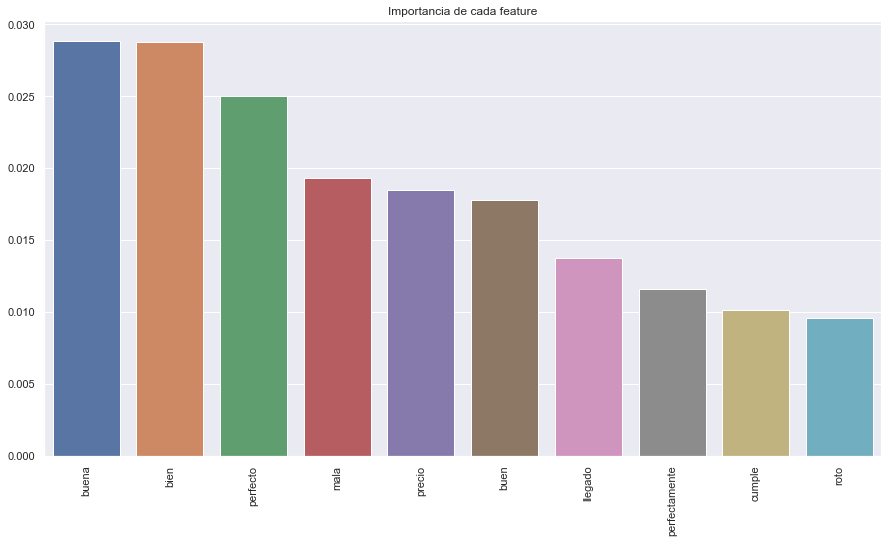

In [81]:
# Por ultimo graficamos
plt.figure(figsize = (15,8))
plt.title('Importancia de cada feature')
plt.xticks(rotation = 90)
sns.barplot(selected_columns, selected_importances)
plt.show()

En el gráfico podemos observa que las  palabras que tuvieron un meyor peso para predecir el tipo de críticas por el modelo de RandomforestClassifier fueron: "buena", "bien" y "perfecto".



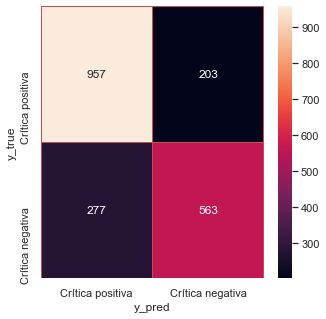

In [125]:
# Realizamos la matriz de confusión
y_pred=best_random.predict(X_test)
confusion(y_test,y_pred)

Al igual que el modelo con los parámetros por defecto, fue más eficiente para predecir las críticas positivas.

In [83]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Positiva', 'Negativa']))


Classification Report

              precision    recall  f1-score   support

    Positiva       0.75      0.87      0.81      1160
    Negativa       0.77      0.60      0.68       840

    accuracy                           0.76      2000
   macro avg       0.76      0.74      0.74      2000
weighted avg       0.76      0.76      0.75      2000



Todas las métricas dan como mejor rendimiento a la predicción sobre las críticas positivas

### Modelo LinearSVC

In [84]:
# INstanciamos el modelo
svc = LinearSVC()

In [85]:
# Entrenamos el modelo
svc.fit(X_train, y_train)

LinearSVC()

In [86]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo LinearSVC es : ", svc.score(X_test, y_test))

La exactitud del modelo LinearSVC es :  0.757


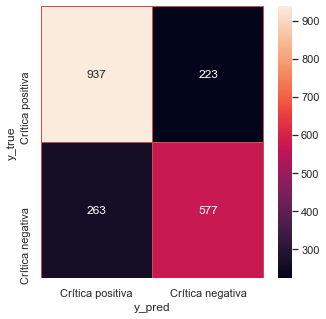

In [87]:
y_pred=svc.predict(X_test)
confusion(y_test,y_pred)

El modelo tiene un mejor rendimiento prediciendo las críticas positivas

In [88]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Positiva', 'Negativa']))


Classification Report

              precision    recall  f1-score   support

    Positiva       0.78      0.81      0.79      1160
    Negativa       0.72      0.69      0.70       840

    accuracy                           0.76      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.76      0.76      0.76      2000



Al igual que los demás modelos, las predicciones son más eficientes para las críticas positivas

#### Optimización de hiperparámetros

In [89]:
# Instanciamos el modelo
svc = LinearSVC()

In [90]:
# Generamos la grilla
# C: regularización. Peso asignado a los errores. Si es alto, clasifica todos los puntos de manera correcta, pero aumenta la posibilidad de sobre ajuste. 
C = [0.1,1, 10, 100]


# Creamos la grilla
random_grid = {'C': C
               }
print(random_grid)

{'C': [0.1, 1, 10, 100]}


In [91]:
# Usamos la grilla para buscar los mejores hiperparámetros
# Primero creamos el modelo base para optimizar
# Random search de hiperparámtros usando una validación cruzada  de 3 K-folds
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1, random_state=42)

In [92]:
# Entrenamos
svc_random.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.3s finished


RandomizedSearchCV(cv=3, estimator=LinearSVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100]},
                   random_state=42, verbose=2)

In [93]:
scores = pd.DataFrame(svc_random.cv_results_)
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.960897,0.039768,0.096182,0.009410,0.1,{'C': 0.1},0.772028,0.764529,0.781320,0.772626,0.006868,1
1,1.000663,0.014137,0.096501,0.009589,1,{'C': 1},0.739783,0.740907,0.752438,0.744376,0.005719,2
2,1.167594,0.195808,0.094035,0.021434,10,{'C': 10},0.709786,0.709411,0.722806,0.714001,0.006228,3
3,0.998091,0.018608,0.072004,0.003265,100,{'C': 100},0.687664,0.677915,0.685296,0.683625,0.004152,4


In [94]:
# Instanciamos el modelo base para calcular la mejora
base_model =  LinearSVC()

In [95]:
# Entrenamos el modelo
base_model.fit(X_train, y_train)

LinearSVC()

In [96]:
# Instanciamos la función con el modelo base
base_accuracy = evaluando(base_model, X_test, y_test)

Performance del modelo
Sensibilidad: 0.6869.
Precisión: 0.7212.
Exactitud = 0.76%.


In [97]:
# Evaluamos con el mejor estimador
best_random = svc_random.best_estimator_
random_accuracy = evaluando(best_random, X_test, y_test)

Performance del modelo
Sensibilidad: 0.6821.
Precisión: 0.7691.
Exactitud = 0.78%.


In [98]:
#Imprimimos la mejora
print('La mejora luego de optimizar los hiperparámetros es de {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

La mejora luego de optimizar los hiperparámetros es de 3.10%.


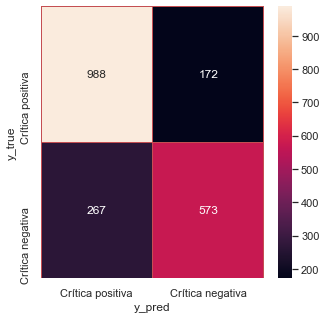

In [99]:
# Realizamos la matriz de confusión
y_pred=best_random.predict(X_test)
confusion(y_test,y_pred)

En la matriz de confusión se observa que el rendimiento fue más eficiente en la predicción de las críticas positivas

In [100]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Positica', 'Negativa']))


Classification Report

              precision    recall  f1-score   support

    Positica       0.79      0.85      0.82      1160
    Negativa       0.77      0.68      0.72       840

    accuracy                           0.78      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.78      0.78      2000



Luego de la opimización, los resultados de las métricas fueron más eficientes para las métricas selecciondas. 

### Modelos XGBClassifier

In [101]:
# Instanciamos el modelo
xgb = XGBClassifier()
print(xgb)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [102]:
# Entrenamos el model
xgb.fit(X_train, y_train)

[19:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo XGB es : ", xgb.score(X_test, y_test))

La exactitud del modelo XGB es :  0.7515


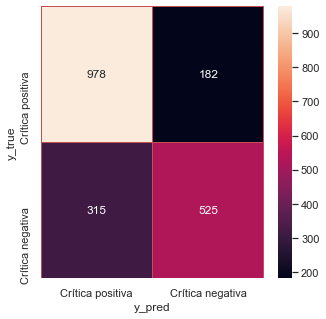

In [104]:
y_pred=xgb.predict(X_test)
confusion(y_test,y_pred)

El modelo obtuvo un mayor proporción de verdaderos positivos para las críticas que fueron positivas. 

In [105]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Positiva', 'Negativa']))


Classification Report

              precision    recall  f1-score   support

    Positiva       0.76      0.84      0.80      1160
    Negativa       0.74      0.62      0.68       840

    accuracy                           0.75      2000
   macro avg       0.75      0.73      0.74      2000
weighted avg       0.75      0.75      0.75      2000



Las 3 métricas seleccionadas tuvieron un mejor rendimiento para las críticas positivas.

In [106]:
# Instanciamos el modelo
xgb_hp = XGBClassifier() 
print(xgb_hp)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [107]:
random_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500]
    }

In [108]:
# Instanciamos el modelo
xgb_hp_random = RandomizedSearchCV(estimator = xgb_hp, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [109]:
# Entrenamos
xgb_hp_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 87.3min finished


[21:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [110]:
# Imprimimos los mejores parámetros
print("Mejores parametros: "+str(xgb_hp_random.best_params_))
print("Mejor Score: "+str(xgb_hp_random.best_score_)+'\n')

scores = pd.DataFrame(xgb_hp_random.cv_results_)
scores

Mejores parametros: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mejor Score: 0.7635015709307904



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,118.845339,1.196232,0.432511,0.018374,0.7,200,3,7,0.01,0.5,"{'subsample': 0.7, 'n_estimators': 200, 'min_c...",0.695913,0.695538,0.691298,0.694250,0.002093,72
1,30.569966,0.418583,0.396698,0.059773,0.7,100,5,3,0.01,0.7,"{'subsample': 0.7, 'n_estimators': 100, 'min_c...",0.622422,0.644544,0.635409,0.634125,0.009077,100
2,275.380863,0.633299,0.494265,0.050922,0.5,500,1,7,0.1,0.7,"{'subsample': 0.5, 'n_estimators': 500, 'min_c...",0.745782,0.766029,0.768567,0.760126,0.010196,4
3,55.392882,1.557823,0.456726,0.045152,0.5,100,3,7,0.01,0.5,"{'subsample': 0.5, 'n_estimators': 100, 'min_c...",0.674541,0.682415,0.683421,0.680125,0.003970,81
4,74.768787,1.444738,0.428705,0.063699,0.7,100,1,7,0.01,0.7,"{'subsample': 0.7, 'n_estimators': 100, 'min_c...",0.672666,0.679415,0.674794,0.675625,0.002817,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,221.892617,2.084394,0.458541,0.027667,0.5,500,5,7,0.1,0.5,"{'subsample': 0.5, 'n_estimators': 500, 'min_c...",0.729659,0.739033,0.745311,0.738001,0.006432,43
96,28.842852,0.185830,0.374696,0.027110,0.5,100,5,3,0.1,0.7,"{'subsample': 0.5, 'n_estimators': 100, 'min_c...",0.714661,0.733783,0.725806,0.724750,0.007842,50
97,119.251545,0.950773,0.401032,0.024099,0.5,200,1,7,0.01,0.5,"{'subsample': 0.5, 'n_estimators': 200, 'min_c...",0.699663,0.701537,0.698800,0.700000,0.001143,66
98,41.535736,1.139982,0.403701,0.019942,0.7,100,5,5,0.01,0.7,"{'subsample': 0.7, 'n_estimators': 100, 'min_c...",0.643795,0.668916,0.656414,0.656375,0.010256,93


In [111]:
# Instanciamos un modelo base
base_model = XGBClassifier() 
base_model.fit(X_train, y_train)

[21:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
# Evaluamos con el mejor estimador
best_random = xgb_hp_random.best_estimator_
random_accuracy = evaluando(best_random, X_test, y_test)

Performance del modelo
Sensibilidad: 0.6702.
Precisión: 0.7350.
Exactitud = 0.76%.


In [113]:
# Instanciamos la función con el modelo base
base_accuracy = evaluando(base_model, X_test, y_test)

Performance del modelo
Sensibilidad: 0.6250.
Precisión: 0.7426.
Exactitud = 0.75%.


In [114]:
# Imprimimos la mejora
print('Mejora del {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Mejora del 1.13%.


In [115]:
# Instanciamos el modelo con mejor rendimiento
xgb_hp = xgb_hp_random.best_estimator_

In [116]:
# Entrenamos el modelo c
xgb_hp.fit(X_train, y_train)

[21:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

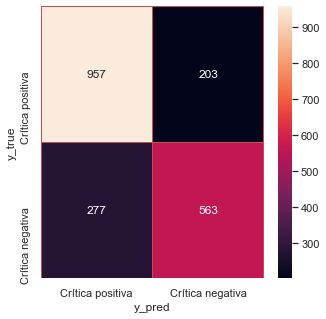

In [117]:
# Realizamos la matriz de confusión
y_pred=best_random.predict(X_test)
confusion(y_test,y_pred)

Nuevamente las críticas positivas obtuvieron un mejor rendimiento en la predicción.

In [118]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Positiva', 'Negativa']))


Classification Report

              precision    recall  f1-score   support

    Positiva       0.78      0.82      0.80      1160
    Negativa       0.73      0.67      0.70       840

    accuracy                           0.76      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.76      0.76      2000



Las 3 métricas seleccionadas obtuvieron un mejor rendimiento para las críticas positivas.

## Comparando los resultados

Vamos a comprar los rendimientos de los modelos mediante la exactitud como métrica.

In [119]:
# Definimos la función para accuracy
def comparar_modelos(train, label):
    results={}
    def test_model(clf):
        
        y_test_pred = clf.predict(train)
        accuracy_test = accuracy_score(label, y_test_pred)
        return accuracy_test


    
    clf = benchmark
    results["Benchmark"]= benchmark
    
    clf = nb
    results["Naive Bayes"]=test_model(clf)
    
    clf = best_random
    results["Random Forest"]=test_model(clf)
    
    clf = svc_random.best_estimator_
    results["Linear svc"]=test_model(clf)

    clf = xgb_hp
    results["XGB Classifier"]=test_model(clf)   
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns=['Accuracy']
    results = pd.DataFrame(results['Accuracy'].sort_values(ascending=False))
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    
    return results

,Accuracy
Linear svc,0.7805
XGB Classifier,0.7600
Random Forest,0.7600
Naive Bayes,0.6910
Benchmark,0.5000


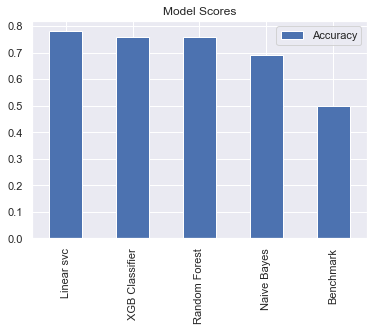

In [120]:
comparar_modelos(X_test, y_test)

En el gráfico de barras podemos observar que el modelo con mejor rendimiento fue el SVCLinear.

## Conclusiones y respuestas a las preguntas planteadas

En principio, se observó que el rendimiento de todos los modelos fue más eficiente para las críticas positivas. Posiblemente, la razón sea que al separar las críticas por cantidad de estrellas en la calificación, quedó una mayor cantidad de críticas como positivas, permitiendo al modelo obtener más información y por lo tanto, un mejor rendimiento que en las críticas negativas. Una solución sería categorizar las calificaciones con 1 y 2 estrellas como negativas, 4 y 5 como positivas y retirar las críticas con 3 estrellas. 

#### Punto 1.

La lemmatización en español, con la librería Spacy es una buena opción además de stemizar. La única contra es que requiere mucho más tiempo de procesamiento que la stemización

### Punto 2

La función de TfidfVectorizer de Sklearn es más eficiente que la vectorización común porque permite que las palabras con menor frecuencia jueguen un rol más relevante para la predicción

### Punto 3

El rendimiento de los modelos, luego de llevar la variable respuesta a otra variable binaria fue más eficiente. La reducción de las posibilidades en la predicción permitieron que los modelos puedan obtener mejores métricas. EL trade off, es la pérdida de información en la predicción. No podemos determinar qué críticas nos permiten predecir la cantidad de estrellas en la calificación. 

Discriminar las palabras que llevan a discriminar entre una calificación de 4 y 5 estrellas podría ser el siguiento paso, al igual que hacerlo con las calificaciones con 1 y 2 estrellas. 

Para las críticas con 3 estrellas, se podría realizar otro análisis como críticas neutras o no neutras. 



### Punto 4 

Por último, el modelo SVCLinear de Sklearn fue el que obtuvo el mejor rendimiento. Sin embargo el modelo XGBoostClassifier obtuvo mejore métricas que el RandomForestClassifier